# Leaf Classification CNN

## Libraries

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#%tensorflow_version 2.x

import tensorflow as tf
import numpy as np
import cv2
import os, shutil, glob, random, csv, time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split



## Data IO

In [2]:
def load_image(file_path):
    return cv2.imread(file_path)

def label_legend(label_file):
    names = []
    legend = dict()
    with open(label_file, newline='') as f:
        reader = csv.reader(f)
        label_dict = dict(reader)
    for name in label_dict.values():
        if name not in names and name != 'label':
            names.append(name)
    names.sort()
    for i, name in enumerate(names):
        legend[name] = i

    csv_name = 'label_legend.csv'
    with open(csv_name, 'w') as csvfile:
        for key in legend.keys():
            csvfile.write("%s,%d\n"%(key, legend[key]))
      
def extract_labels(label_file):
    with open('label_legend.csv', newline='') as f:
        reader = csv.reader(f)
        legend = dict(reader)
    with open(label_file, newline='') as f:
        reader = csv.reader(f)
        label_dict = dict(reader)
    labels = []
    for key in label_dict.keys():
        if label_dict[key] in legend:
            labels.append(int(legend[label_dict[key]]))  
    return labels

def extract_names(label_file):
    names = list()
    with open('label_legend.csv', newline='') as f:
        reader = csv.reader(f)
        legend = dict(reader)
    for img in label_file:
        names.append(legend[str(img)])
    return names
    
            

In [3]:
def create_directory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        pass

def process_data(source_path, dest_path, desired_size):
    create_directory(dest_path)
    names = []
    legend = dict()
    j=0
    species_folders = os.listdir(source_path)
    for i, folder in enumerate(species_folders):
        id = str(i).rjust(2, '0')
        legend[folder] = id
        folder_path = os.listdir(os.path.join(source_path, folder))
        for jpgfile in folder_path:
            #resize
            img = load_image(os.path.join(source_path, folder, jpgfile))
            old_size = img.shape[:2]
            ratio = float(desired_size)/max(old_size)
            new_size = tuple([int(x*ratio) for x in old_size])
            img = cv2.resize(img, (new_size[1], new_size[0]))
            delta_w = desired_size - new_size[1]
            delta_h = desired_size - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)

            color = [0, 0, 0]
            new_im = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT,
                value=color)
            new_im = cv2.cvtColor(new_im, cv2.COLOR_BGR2GRAY)
            (thresh, new_im) = cv2.threshold(new_im, 127, 255, cv2.THRESH_BINARY)
    
            #rename
            new_name = id + str(j) + '.jpg'
            j += 1
            fname = os.path.join(dest_path, new_name)
            cv2.imwrite(fname, new_im)
            #shutil.copy(jpgfile, os.path.join(dest_path, new_name))        
    csv_name = 'label_legend.csv'
    with open(csv_name, 'w') as csvfile:
        for key in legend.keys():
            csvfile.write("%d,%s\n"%(int(legend[key]), key))
            

In [4]:
root_path = os.path.join(os.getcwd(), 'datasets')
#root_path = os.path.join(os.getcwd(), 'drive', 'My Drive', 'datasets')

t0 = time.clock()
dest_name = 'sixty_four'
desired_size = 64
dest_path = os.path.join(root_path, dest_name)
process_data(os.path.join(root_path, '100 leaves plant species', 'data'), dest_path, desired_size)
t1 = time.clock() - t0
print("Time elapsed: ", t1 - t0)

Time elapsed:  6.598482199999999


In [5]:
data_path = dest_path
image_files = os.listdir(dest_path)
data = [load_image(os.path.join(data_path, file)) for file in image_files]
labels = [int(file[:2]) for file in image_files]
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=.25, random_state=101)
test_label_name = extract_names(test_labels)
#print("training images: ", train_images[:10])
print("training labels: ", train_labels[:10])
#print("testing images: ", test_images[:10])
print("testing labels: ", test_labels[:10])
print("testing names:", test_label_name[:10])

training labels:  [77, 53, 56, 84, 54, 33, 11, 50, 92, 63]
testing labels:  [42, 59, 91, 67, 56, 69, 82, 21, 70, 63]
testing names: ['Morus_Nigra', 'Quercus_Coccifera', 'Salix_Intergra', 'Quercus_Ilex', 'Quercus_Castaneifolia', 'Quercus_Infectoria_sub', 'Quercus_Suber', 'Celtis_Koraiensis', 'Quercus_Kewensis', 'Quercus_Dolicholepis']


### Image Preprocessing

In [6]:
def preprocess(img, side=32):
    #img = cv2.resize(img, (side,side))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (thresh, img) = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
    return img / 255.0

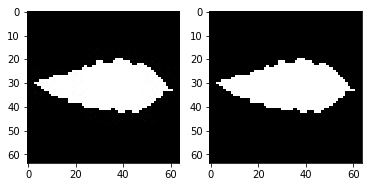

In [7]:
preview_index = 2
plt.subplot(1,2,1)
plt.imshow(train_images[preview_index])
#data already mostly processed
plt.subplot(1,2,2)
plt.imshow(preprocess(train_images[preview_index]), cmap="gray")

In [8]:
#effectively just reduces rgb[3] to binary
for i in range(len(train_images)):
    train_images[i] = preprocess(train_images[i])

for i in range(len(test_images)):
    test_images[i] = preprocess(test_images[i])

In [9]:
train_images = np.expand_dims(train_images, axis=-1)
train_labels = np.array(train_labels)
print(type(train_images[0]), type(train_labels[0]))
print(train_labels[:15])
print(train_images.shape, train_labels.shape)

<class 'numpy.ndarray'> <class 'numpy.int32'>
[77 53 56 84 54 33 11 50 92 63 86 27 53 69 19]
(1200, 64, 64, 1) (1200,)


## CONV NET

In [13]:
layers = [
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding="same", activation=tf.nn.relu, input_shape=train_images.shape[1:]),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation=tf.nn.relu),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=256, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=100, activation=tf.nn.softmax)
]

model = tf.keras.Sequential(layers)
model.compile(optimizer=tf.optimizers.Adam(),
              loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.metrics.SparseCategoricalAccuracy()])
model.fit(train_images, train_labels, epochs=15, batch_size=50)
model.save_weights("model.tf")

Train on 1200 samples
Epoch 1/15
1200/1200 [==============================] - 4s 4ms/sample - loss: 4.6094 - sparse_categorical_accuracy: 0.0100
Epoch 2/15
1200/1200 [==============================] - 4s 3ms/sample - loss: 4.3320 - sparse_categorical_accuracy: 0.0333
Epoch 3/15
1200/1200 [==============================] - 3s 3ms/sample - loss: 3.4282 - sparse_categorical_accuracy: 0.0908
Epoch 4/15
 600/1200 [==============>...............] - ETA: 1s - loss: 2.7511 - sparse_categorical_accuracy: 0.1891WARNING:tensorflow:Unresolved object in checkpoint: (root).optimizer


KeyboardInterrupt: 

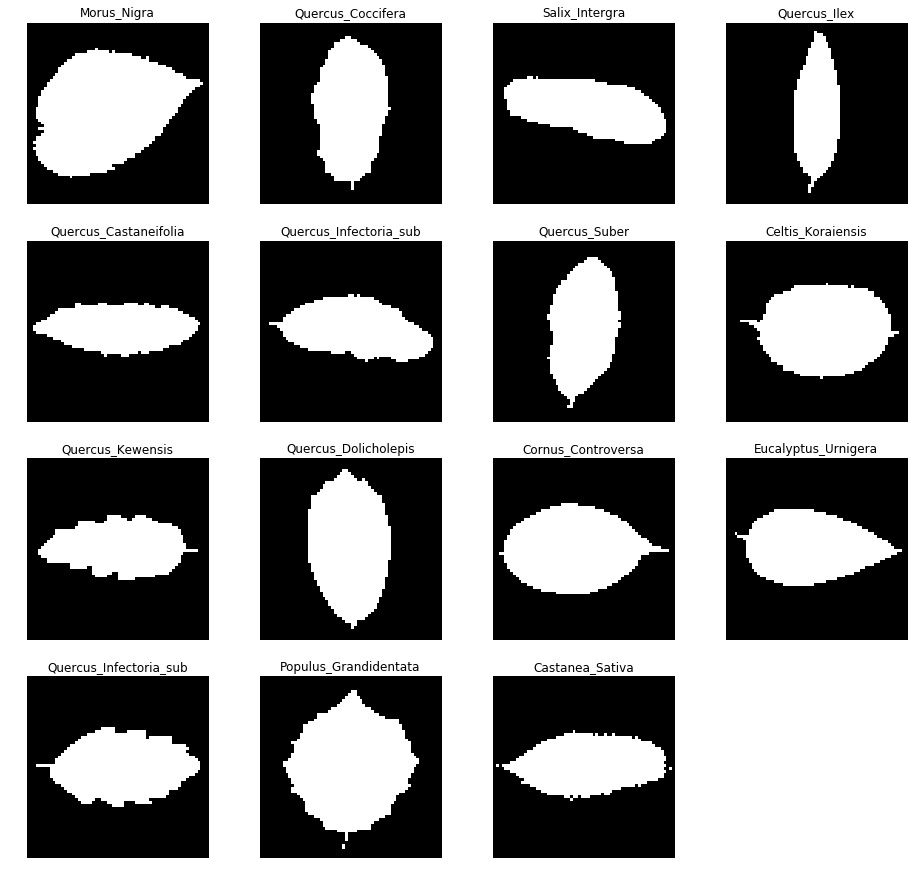

In [12]:
eval_model = tf.keras.Sequential(layers)
eval_model.load_weights("model.tf")
eval_predictions = eval_model.predict(np.expand_dims(test_images, axis=-1))
cols = 4
rows = np.ceil(len(test_images)/cols)
fig = plt.gcf()
fig.set_size_inches(cols * 4, rows * 4)
for i in range(15):
    plt.subplot(rows, cols, i+1)
    plt.imshow(test_images[i], cmap="gray")
    plt.title(test_label_name[i])
    plt.axis('off')